In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-ns/navier_stokes_v1e-5_N1200_T20_a.npy
/kaggle/input/data-ns/navier_stokes_v1e-5_N1200_T20_u.npy
/kaggle/input/data-ns/navier_stokes_v1e-5_N1200_T20_t.npy


## **Cell 1: Setup, Data Loading & Preparation**
First, we'll install the required library and use its built-in data handler to download and prepare the Navier-Stokes dataset. This automates the entire data pipeline.

In [ ]:
# jhagnberger/fno-vorticity

In [2]:
# --- Installation and Import ---
!pip install -q -U neuraloperator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 57.1 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.9/186.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 111.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.4/255.4 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 102.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# Cell 1: Setup, Data Loading & Preparation
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import time

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Define File Path ---
# Path to the directory where you've placed the files
data_dir = "/kaggle/input/data-ns/"
data_file = "navier_stokes_v1e-5_N1200_T20_u.npy"
filepath = data_dir + data_file

# --- Load and Process Data from .npy file ---
print(f"Loading data from: {filepath}")
# The data is in shape (N, H, W, T) -> (1200, 64, 64, 20)
raw_data = np.load(filepath)
data = torch.from_numpy(raw_data).float()

# We want to map the first 10 timesteps to the 11th
x_data = data[..., :10] # Input t=0 to t=9
y_data = data[..., 10:11] # Target t=10

# Permute dimensions for PyTorch: (N, H, W, T) -> (N, T, H, W)
x_data = x_data.permute(0, 3, 1, 2)
y_data = y_data.permute(0, 3, 1, 2)

# --- Create the Train/Test Split ---
n_train = 1000
n_test = 200
batch_size = 20

train_x, train_y = x_data[:n_train], y_data[:n_train]
test_x, test_y = x_data[-n_test:], y_data[-n_test:]

# --- Create PyTorch TensorDatasets and DataLoaders ---
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nSuccessfully created {len(train_loader)} training batches of size {batch_size}.")
print(f"Successfully created {len(test_loader)} testing batches of size {batch_size}.")

# Let's inspect a single batch to see the data shape
x_sample, y_sample = next(iter(train_loader))
print(f"Sample input shape: {x_sample.shape}")
print(f"Sample output shape: {y_sample.shape}")

Using device: cuda
Loading data from: /kaggle/input/data-ns/navier_stokes_v1e-5_N1200_T20_u.npy

Successfully created 1 training batches of size 20.
Successfully created 1 testing batches of size 20.
Sample input shape: torch.Size([20, 10, 64, 64])
Sample output shape: torch.Size([20, 1, 64, 64])


## **Cell 2: The Modified FNO Model**
We first define the core SpectralConv2d layer and then use it to build our ModifiedFNO class, which includes the specified width, modes, and integrated Layer Normalization.

In [4]:
import torch.nn as nn
import torch.nn.functional as F

# --- Model Hyperparameters ---
MODES = 20
WIDTH = 72
N_LAYERS = 4
IN_CHANNELS = 12   # 10 input timesteps + 2 grid coordinates
OUT_CHANNELS = 1

# #################################################################
# # 2D Fourier layer 
# #################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

# #################################################################
# # The main FNO model 
# #################################################################
class ModifiedFNO(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(ModifiedFNO, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.fc0 = nn.Linear(IN_CHANNELS, self.width)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.norm0 = nn.LayerNorm([self.width, 64, 64])
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.norm1 = nn.LayerNorm([self.width, 64, 64])
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.norm2 = nn.LayerNorm([self.width, 64, 64])
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.norm3 = nn.LayerNorm([self.width, 64, 64])
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, OUT_CHANNELS)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = self.norm0(x1 + x2)
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = self.norm1(x1 + x2)
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = self.norm2(x1 + x2)
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = self.norm3(x1 + x2)

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = x.permute(0, 3, 1, 2)

        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[2], shape[3]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, 1, size_x, 1).repeat([batchsize, 1, 1, size_y])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        # --- THIS IS THE LINE THAT IS NOW FIXED ---
        gridy = gridy.reshape(1, 1, 1, size_y).repeat([batchsize, 1, size_x, 1])
        return torch.cat((gridx, gridy), dim=1).to(device)


# --- Instantiate the custom model ---
model = ModifiedFNO(MODES, MODES, WIDTH).to(device)

# --- Print Model Summary ---
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model.__class__.__name__}")
print(f"Number of trainable parameters: {num_params}")

Model: ModifiedFNO
Number of trainable parameters: 18979529


## **Cell 3: Helper Utilities & Custom Loss Function**
This cell contains our helper classes. We'll define the standard LpLoss for evaluation (to compare with the paper's results) and our new, more sophisticated SobolevLoss for training. The SobolevLoss penalizes errors in both the function values and their spatial derivatives, making it well-suited for fluid dynamics.

In [7]:
class LpLoss(object):
    """Standard LpLoss for evaluation, as used in the FNO paper."""
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms / y_norms)
            else:
                return torch.sum(diff_norms / y_norms)
        return diff_norms / y_norms

    def __call__(self, x, y):
        return self.rel(x, y)


class SobolevLoss(nn.Module):
    """
    A loss function that penalizes both the L2 norm of the error and the
    L2 norm of the error in the spatial gradients. This is ideal for PDEs.
    """
    def __init__(self, lambda_grad=1e-2):
        super(SobolevLoss, self).__init__()
        self.lambda_grad = lambda_grad
        
        # Create finite difference kernels for gradients
        # Sobel filters could also be used here
        dx = torch.tensor([[[[1, 0, -1], [2, 0, -2], [1, 0, -1]]]], dtype=torch.float32).to(device)
        dy = torch.tensor([[[[1, 2, 1], [0, 0, 0], [-1, -2, -1]]]], dtype=torch.float32).to(device)
        self.dx = dx
        self.dy = dy

    def find_grads(self, func):
        grad_x = F.conv2d(func, self.dx, padding='same')
        grad_y = F.conv2d(func, self.dy, padding='same')
        return grad_x, grad_y

    def forward(self, pred, target):
        # L2 norm of the function value error
        l2_loss = F.mse_loss(pred, target)

        # L2 norm of the gradient error
        pred_dx, pred_dy = self.find_grads(pred)
        target_dx, target_dy = self.find_grads(target)
        
        grad_loss = F.mse_loss(pred_dx, target_dx) + F.mse_loss(pred_dy, target_dy)
        
        # Combine the two losses
        return l2_loss + self.lambda_grad * grad_loss

print("Helper Utilities & Custom Loss Function Set")

Helper Utilities & Custom Loss Function Set


## **Cell 4: Testing / Evaluation Function**
This cell contains the function that evaluates our model on the test dataset. It's called at the end of each training epoch to monitor performance and save the best model. We use the standard LpLoss here for fair comparison with published results.

In [8]:
def evaluate(model, loader, loss_fn, device):
    """
    Evaluates the model on the provided data loader using the specified loss function.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred.squeeze(), y.squeeze())
            total_loss += loss.item()
            
    return total_loss / len(loader)

print("Evaluate functions set")

Evaluate functions set


## **Cell 5: Training Loop**
Now we'll write the main training loop. It will instantiate the model, optimizer, and our custom loss, then iterate through the data for a fixed number of epochs, saving the best model based on test performance.

In [9]:
# --- Training Hyperparameters ---
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
SCHEDULER_STEP = 20
SCHEDULER_GAMMA = 0.5

# --- Instantiate training components ---
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP, gamma=SCHEDULER_GAMMA)
training_loss_fn = SobolevLoss().to(device)
eval_loss_fn = LpLoss()

print("Starting training...")
best_test_loss = float('inf')

for epoch in range(EPOCHS):
    model.train()
    epoch_start_time = time.time()
    train_loss = 0.0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        pred = model(x)
        
        loss = training_loss_fn(pred, y)
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)
    scheduler.step()
    
    # --- Evaluation on test set (defined in the next cell) ---
    test_loss = evaluate(model, test_loader, eval_loss_fn, device)
    epoch_end_time = time.time()
    
    print(f"Epoch: {epoch+1}/{EPOCHS} | Time: {epoch_end_time - epoch_start_time:.2f}s | "
          f"Train Loss: {train_loss:.4f} | Test Rel. L2 Loss: {test_loss:.4f}")
          
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), 'fno_ns_best_model.pth')
        print("  New best model saved!")

print("\nTraining finished.")
print(f"Best test relative L2 loss: {best_test_loss:.4f}")

Starting training...
Epoch: 1/100 | Time: 0.96s | Train Loss: 1.4139 | Test Rel. L2 Loss: 0.6645
  New best model saved!
Epoch: 2/100 | Time: 0.12s | Train Loss: 0.6864 | Test Rel. L2 Loss: 0.5350
  New best model saved!
Epoch: 3/100 | Time: 0.12s | Train Loss: 0.4237 | Test Rel. L2 Loss: 0.5680
Epoch: 4/100 | Time: 0.12s | Train Loss: 0.3042 | Test Rel. L2 Loss: 0.5703
Epoch: 5/100 | Time: 0.10s | Train Loss: 0.2378 | Test Rel. L2 Loss: 0.5019
  New best model saved!
Epoch: 6/100 | Time: 0.10s | Train Loss: 0.1917 | Test Rel. L2 Loss: 0.3733
  New best model saved!
Epoch: 7/100 | Time: 0.11s | Train Loss: 0.1514 | Test Rel. L2 Loss: 0.2947
  New best model saved!
Epoch: 8/100 | Time: 0.10s | Train Loss: 0.1197 | Test Rel. L2 Loss: 0.2592
  New best model saved!
Epoch: 9/100 | Time: 0.10s | Train Loss: 0.0832 | Test Rel. L2 Loss: 0.2498
  New best model saved!
Epoch: 10/100 | Time: 0.10s | Train Loss: 0.0640 | Test Rel. L2 Loss: 0.2667
Epoch: 11/100 | Time: 0.10s | Train Loss: 0.0628 |

## **Cell 6: Inference and Visualization**
Finally, let's load our best-trained model and perform inference on a random example from the test set. We'll visualize the ground truth (from the high-fidelity solver), our FNO's prediction, and the error between them. This gives a powerful qualitative assessment of the model's performance.

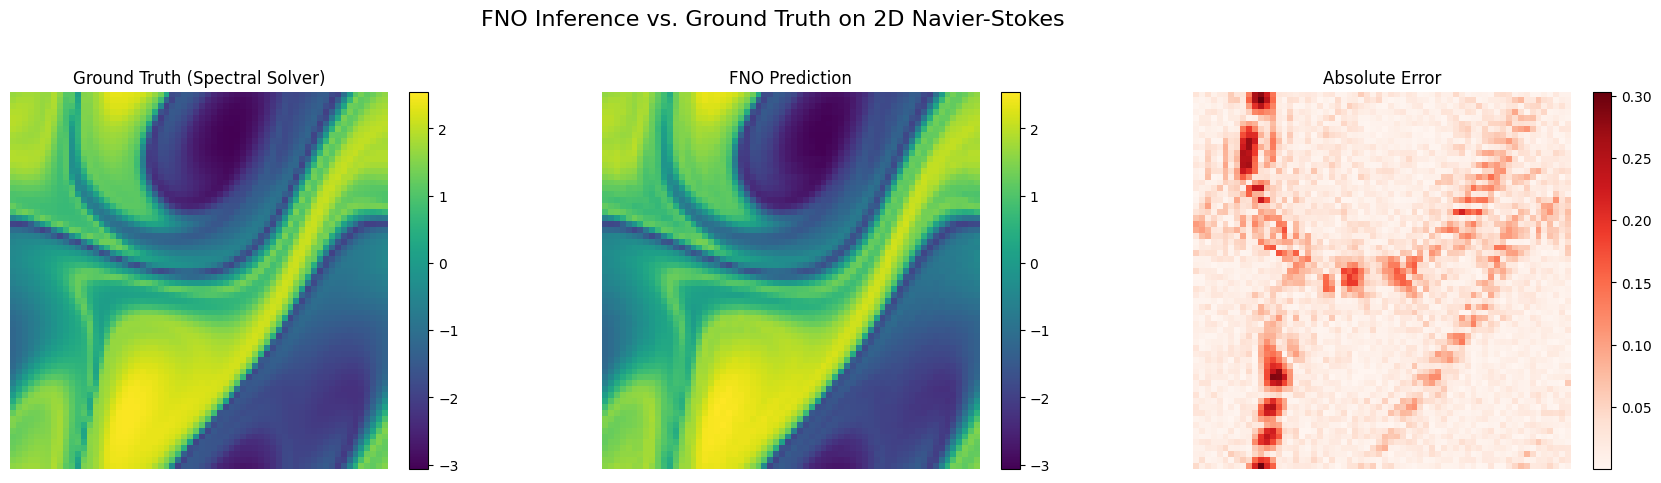

In [10]:
# --- Load the best model ---
model.load_state_dict(torch.load('fno_ns_best_model.pth'))
model.eval()

# --- Get a random sample from the test set ---
x_test, y_test = next(iter(test_loader))
sample_idx = np.random.randint(0, x_test.shape[0])

x_sample = x_test[sample_idx:sample_idx+1].to(device)
y_true = y_test[sample_idx:sample_idx+1].to(device)

# --- Perform inference ---
with torch.no_grad():
    y_pred = model(x_sample)

# --- Move data to CPU for plotting ---
y_true = y_true.squeeze().cpu().numpy()
y_pred = y_pred.squeeze().cpu().numpy()
error = np.abs(y_true - y_pred)

# --- Plot the results ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('FNO Inference vs. Ground Truth on 2D Navier-Stokes', fontsize=16)
vmax = max(y_true.max(), y_pred.max())
vmin = min(y_true.min(), y_pred.min())

# Plot Ground Truth (Spectral Solver)
im1 = axes[0].imshow(y_true, cmap='viridis', vmax=vmax, vmin=vmin)
axes[0].set_title('Ground Truth (Spectral Solver)', fontsize=12)
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Plot FNO Prediction
im2 = axes[1].imshow(y_pred, cmap='viridis', vmax=vmax, vmin=vmin)
axes[1].set_title('FNO Prediction', fontsize=12)
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Plot Absolute Error
im3 = axes[2].imshow(error, cmap='Reds')
axes[2].set_title('Absolute Error', fontsize=12)
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()